In [2]:
!pip install yfinance pandas textblob newsapi-python


In [14]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
from textblob import TextBlob
from newsapi import NewsApiClient

# Initialize News API client
newsapi = NewsApiClient(api_key='a776b20cd6fa4194bf886426eb79d5ab')  # Replace with your API key

# Load portfolio from CSV
def load_portfolio(csv_file):
    portfolio = pd.read_csv(csv_file)
    if 'Ticker' not in portfolio.columns:
        raise ValueError("CSV file must contain a 'Ticker' column.")
    return portfolio

# Fetch stock price data
def get_stock_data(ticker, start_date="2023-01-01"):
    stock = yf.Ticker(ticker)
    data = stock.history(period="1d", start=start_date)['Close']

    if not data.empty:
        return data
    else:
        print(f"Warning: No data found for {ticker}")
        return None

# Calculate portfolio risk metrics
def calculate_risk_metrics(portfolio):
    price_data = {ticker: get_stock_data(ticker) for ticker in portfolio['Ticker']}

    # Convert dictionary to DataFrame
    combined_data = pd.DataFrame({ticker: data for ticker, data in price_data.items() if data is not None})

    # Compute daily returns
    returns = combined_data.pct_change().dropna()

    # Calculate risk metrics
    volatility = returns.std() * np.sqrt(252)  # Annualized Volatility
    correlation_matrix = returns.corr()
    var_95 = returns.quantile(0.05)  # 95% Value-at-Risk
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # Assuming risk-free rate of 0%

    # Max Drawdown
    cumulative_returns = (1 + returns).cumprod()
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()

    # Conditional Value-at-Risk (CVaR)
    cvar = returns[returns <= var_95].mean()

    # Sortino Ratio
    downside_returns = returns[returns < 0]
    sortino_ratio = returns.mean() / downside_returns.std() * np.sqrt(252)

    return volatility, correlation_matrix, var_95, sharpe_ratio,max_drawdown, cvar, sortino_ratio

# Portfolio Optimization (Mean-Variance Optimization)
def optimize_portfolio(returns):
    def objective(weights):
        portfolio_return = np.dot(weights, returns.mean())
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        return -portfolio_return / portfolio_volatility  # Maximize Sharpe Ratio (return/volatility)

    num_assets = len(returns.columns)
    initial_weights = np.ones(num_assets) / num_assets
    bounds = tuple((0, 1) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Calculate Beta (Market Risk)
def calculate_beta(stock_returns, market_returns):
    cov_matrix = np.cov(stock_returns, market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    return beta

# Risk mitigation suggestions
def risk_mitigation_suggestions(volatility, correlation_matrix, sharpe_ratio, var_95):
    suggestions = []

    # Diversification check
    avg_correlation = correlation_matrix.mean().mean()
    if avg_correlation > 0.6:
        suggestions.append("Your portfolio is highly correlated. Consider adding uncorrelated assets like bonds or commodities.")

    # Volatility check
    high_volatility_stocks = volatility[volatility > 0.3]
    if not high_volatility_stocks.empty:
        suggestions.append(f"Stocks with high volatility: {', '.join(high_volatility_stocks.index)}. Consider rebalancing.")

    # Sharpe Ratio
    low_sharpe = sharpe_ratio[sharpe_ratio < 1]
    if not low_sharpe.empty:
        suggestions.append(f"Stocks with low Sharpe ratio: {', '.join(low_sharpe.index)}. Consider reducing exposure.")

    # Value at Risk
    if var_95.min() < -0.05:
        suggestions.append("High Value-at-Risk detected. Your portfolio may experience significant losses under adverse conditions.")

    return suggestions

# Stress Testing (simulated scenarios)
def stress_testing(portfolio):
    # Stress test: Hypothetical 10% market drop
    price_data = {ticker: get_stock_data(ticker) for ticker in portfolio['Ticker']}
    combined_data = pd.DataFrame({ticker: data for ticker, data in price_data.items() if data is not None})

    # Calculate stress test returns (assumes -10% market drop)
    market_drop = -0.10
    stress_test_data = combined_data * (1 + market_drop)

    # Compute stress test volatility and returns
    stress_test_returns = stress_test_data.pct_change().dropna()
    stress_test_volatility = stress_test_returns.std() * np.sqrt(252)

    return stress_test_volatility

# Sentiment Analysis (Advanced)
def get_sentiment(ticker):
    try:
        # Fetch articles related to the stock ticker
        articles = newsapi.get_everything(q=ticker, language='en', sort_by='relevancy', page_size=5)
        if articles['totalResults'] > 0:
            headlines = [article['title'] for article in articles['articles']]
            sentiments = [TextBlob(headline).sentiment.polarity for headline in headlines]
            avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
            return avg_sentiment
        else:
            return 0  # No sentiment if no articles are found
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")
        return 0

# Function to calculate stock and market returns
def get_stock_returns(ticker, start_date="2023-01-01"):
    stock_data = get_stock_data(ticker, start_date)
    if stock_data is not None:
        returns = stock_data.pct_change().dropna()
        return returns
    return None

def get_market_returns(index_ticker="^GSPC", start_date="2023-01-01"):
    market_data = get_stock_data(index_ticker, start_date)  # Using S&P 500 as the market index
    if market_data is not None:
        returns = market_data.pct_change().dropna()
        return returns
    return None

# Function to calculate beta (market risk) for each stock
def calculate_beta(stock_returns, market_returns):
    cov_matrix = np.cov(stock_returns, market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    return beta

# Function to check liquidity risk based on average trading volume
def check_liquidity_risk(ticker, threshold=1000000):
    stock = yf.Ticker(ticker)
    data = stock.history(period="1y")['Volume']
    avg_volume = data.mean() if not data.empty else 0
    if avg_volume < threshold:
        return f"{ticker} has low liquidity risk (avg. volume: {avg_volume})"
    else:
        return f"{ticker} has adequate liquidity (avg. volume: {avg_volume})"

# Function for tax-loss harvesting (simple implementation)
def tax_loss_harvesting(portfolio, price_data):
    tax_loss_candidates = []
    for ticker in portfolio['Ticker']:
        # Check if price data is available for the ticker
        if ticker in price_data and price_data[ticker] is not None:
            current_price = price_data[ticker].iloc[-1]  # Latest price (using .iloc to access by position)
            initial_price = price_data[ticker].iloc[0]  # Price when purchased (assumed at start of period)

            # If current price is lower than initial price, it's a loss
            if current_price < initial_price:
                tax_loss_candidates.append(ticker)

    return tax_loss_candidates

# Main execution
csv_file = "Portfolio.csv"
portfolio = load_portfolio(csv_file)

# Fetch stock and market returns
market_ticker = "^GSPC"  # Using S&P 500 as the market index

# Get stock and market returns for beta calculation
stock_returns = {ticker: get_stock_returns(ticker) for ticker in portfolio['Ticker']}
market_returns = get_market_returns(market_ticker)

# Ensure both returns are available before calculating beta
betas = {}
for ticker in portfolio['Ticker']:
    stock_returns = get_stock_returns(ticker)
    if stock_returns is not None and market_returns is not None:
        beta = calculate_beta(stock_returns, market_returns)
        betas[ticker] = beta

# Calculate portfolio risk metrics
volatility, correlation_matrix, var_95, sharpe_ratio, max_drawdown, cvar, sortino_ratio = calculate_risk_metrics(portfolio)

# Stress testing
stress_test_volatility = stress_testing(portfolio)

# Generate suggestions
suggestions = risk_mitigation_suggestions(volatility, correlation_matrix, sharpe_ratio, var_95)

# Display results
print("Portfolio Volatility:\n", volatility)
print("\nCorrelation Matrix:\n", correlation_matrix)
print("\nValue-at-Risk (95% Confidence Level):\n", var_95)
print("\nMax Drawdown:\n", max_drawdown)
print("\nConditional Value-at-Risk (CVaR):\n", cvar)
print("\nSharpe Ratio:\n", sharpe_ratio)
print("\nSortino Ratio:\n", sortino_ratio)
print("\nStress Test Volatility (10% market drop):\n", stress_test_volatility)
print("\nBeta for each stock in the portfolio:\n")
for ticker, beta in betas.items():
    print(f"{ticker}: {beta}")
print("\nRisk Mitigation Suggestions:")
for suggestion in suggestions:
    print("- " + suggestion)

# Portfolio Optimization
returns = pd.DataFrame({ticker: get_stock_returns(ticker) for ticker in portfolio['Ticker'] if get_stock_returns(ticker) is not None})
optimal_weights = optimize_portfolio(returns)
print("\nOptimal Portfolio Weights (Mean-Variance Optimization):\n", optimal_weights)

# Sentiment for each ticker
for ticker in portfolio['Ticker']:
    sentiment = get_sentiment(ticker)
    print(f"\nSentiment for {ticker}:", sentiment)

# Liquidity risk for each ticker
for ticker in portfolio['Ticker']:
    liquidity_risk = check_liquidity_risk(ticker)
    print(f"\nLiquidity Risk for {ticker}:", liquidity_risk)

# Tax Loss Harvesting Candidates
price_data = {ticker: get_stock_data(ticker) for ticker in portfolio['Ticker']}
tax_loss_candidates = tax_loss_harvesting(portfolio, price_data)
print("\nTax Loss Harvesting Candidates:", tax_loss_candidates)


ERROR:yfinance:$AAPL: possibly delisted; no price data found  (1d 2023-01-01 -> 2025-03-31)


Portfolio Volatility:
 AAPL    0.223016
MSFT    0.230491
TSLA    0.600533
AMZN    0.304698
GOOG    0.296288
NVDA    0.525637
META    0.377746
JPM     0.224373
V       0.164390
NFLX    0.345419
AMD     0.471912
DIS     0.258237
PFE     0.228176
WMT     0.183115
dtype: float64

Correlation Matrix:
           AAPL      MSFT      TSLA      AMZN      GOOG      NVDA      META  \
AAPL  1.000000  0.495534  0.390267  0.390222  0.442545  0.315374  0.378770   
MSFT  0.495534  1.000000  0.328590  0.627143  0.533229  0.511813  0.540308   
TSLA  0.390267  0.328590  1.000000  0.375022  0.345272  0.326606  0.293670   
AMZN  0.390222  0.627143  0.375022  1.000000  0.593719  0.420888  0.593547   
GOOG  0.442545  0.533229  0.345272  0.593719  1.000000  0.385565  0.510692   
NVDA  0.315374  0.511813  0.326606  0.420888  0.385565  1.000000  0.402859   
META  0.378770  0.540308  0.293670  0.593547  0.510692  0.402859  1.000000   
JPM   0.167999  0.150779  0.296693  0.215944  0.170691  0.171509  0.167821   


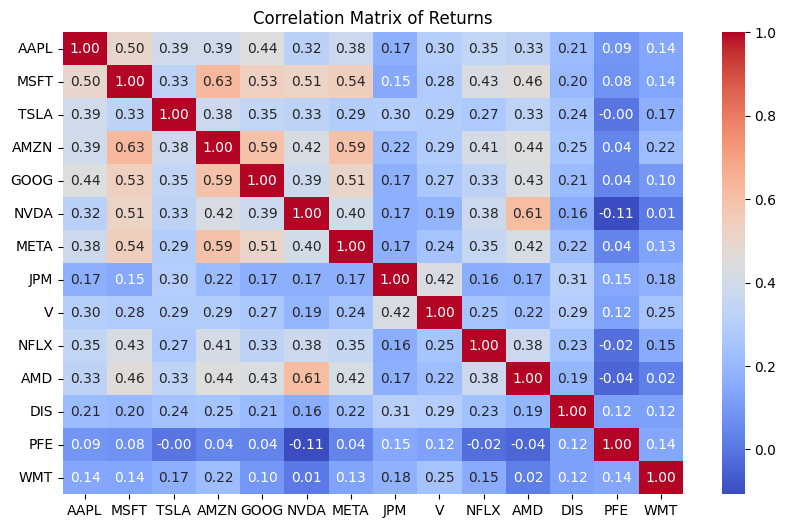

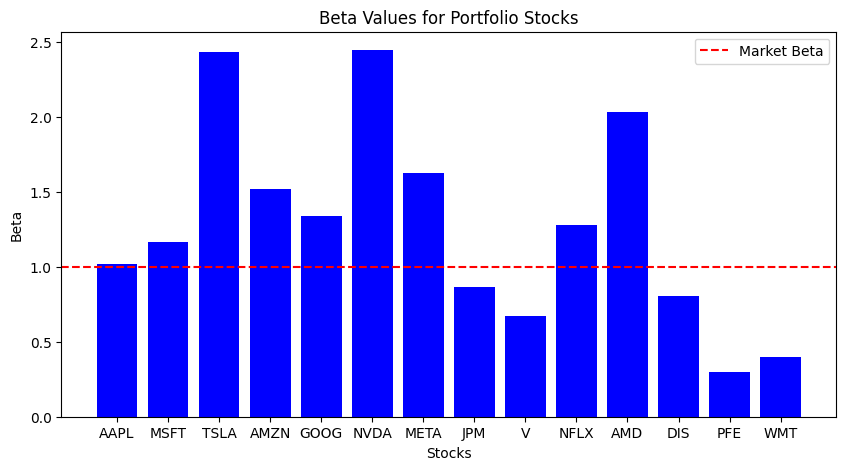


Optimal Portfolio Weights: [0.00000000e+00 0.00000000e+00 6.41268197e-17 0.00000000e+00
 1.57804928e-17 1.33507984e-01 1.49803020e-01 1.45940703e-01
 1.30078084e-01 7.87414524e-02 0.00000000e+00 3.11269886e-17
 1.68513471e-17 3.61928757e-01]


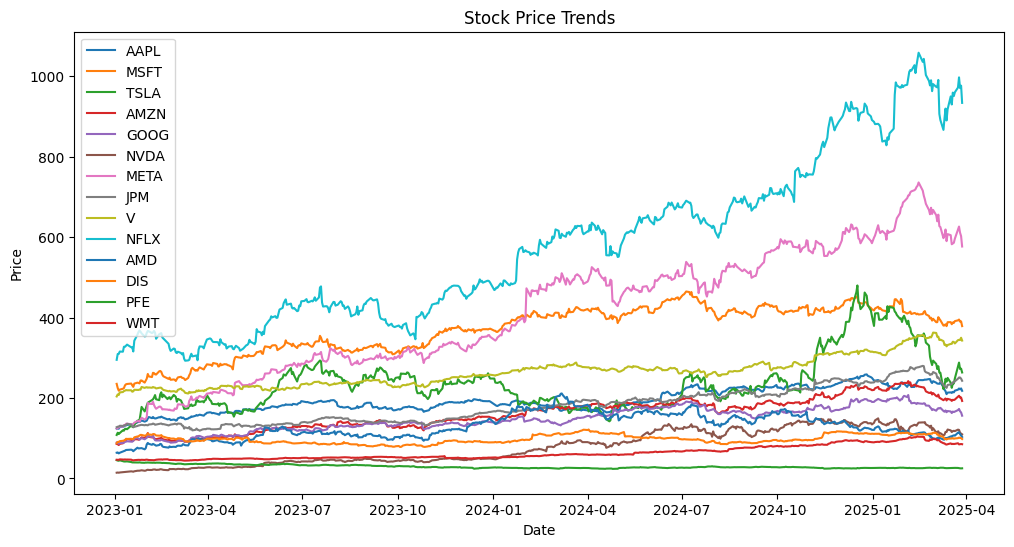

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns




# Visualize stock price trends
def plot_stock_prices(portfolio):
    plt.figure(figsize=(12, 6))
    for ticker in portfolio['Ticker']:
        data = get_stock_data(ticker)
        if data is not None:
            plt.plot(data.index, data.values, label=ticker)
    plt.title("Stock Price Trends")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Calculate portfolio risk metrics
def calculate_risk_metrics(portfolio):
    price_data = {ticker: get_stock_data(ticker) for ticker in portfolio['Ticker']}
    combined_data = pd.DataFrame({ticker: data for ticker, data in price_data.items() if data is not None})
    returns = combined_data.pct_change().dropna()
    correlation_matrix = returns.corr()

    # Visualizing correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix of Returns")
    plt.show()

    return returns

# Calculate beta values
def calculate_beta(stock_returns, market_returns):
    betas = {}
    for ticker in stock_returns.columns:
        cov_matrix = np.cov(stock_returns[ticker].dropna(), market_returns.dropna())
        betas[ticker] = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] != 0 else np.nan

    # Bar chart of beta values
    plt.figure(figsize=(10, 5))
    plt.bar(betas.keys(), betas.values(), color='b')
    plt.axhline(1, color='r', linestyle='--', label='Market Beta')
    plt.xlabel("Stocks")
    plt.ylabel("Beta")
    plt.title("Beta Values for Portfolio Stocks")
    plt.legend()
    plt.show()

    return betas

# Portfolio Optimization
def optimize_portfolio(returns):
    def objective(weights):
        return -np.dot(weights, returns.mean()) / np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))

    num_assets = len(returns.columns)
    initial_weights = np.ones(num_assets) / num_assets
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Load portfolio and process data
csv_file = "Portfolio.csv"
portfolio = load_portfolio(csv_file)
market_ticker = "^GSPC"
market_returns = get_stock_data(market_ticker).pct_change().dropna()
stock_returns = calculate_risk_metrics(portfolio)

# Beta calculation and visualization
betas = calculate_beta(stock_returns, market_returns)

# Portfolio Optimization
optimal_weights = optimize_portfolio(stock_returns)
print("\nOptimal Portfolio Weights:", optimal_weights)

# Stock Price Trends Visualization
plot_stock_prices(portfolio)